#1) Scrap Data

In [0]:
# 1. Définir les configurations avec vos informations d'identification
account_name = "projet2024"
account_key = "lgJb6ipPO6g8oYsxrl9FonRqMgMBzBIzNI+wwUuiqon7f90iOsN+QEzQkIqyBTOhfY6aOMcVIZv0+AStPrw9Ng=="
file_system_name = "staging"

configs = {
    f"fs.azure.account.key.{account_name}.blob.core.windows.net": account_key
}

# Vérifier si le répertoire est déjà monté
mount_point = "/mnt/adls"
if any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.unmount(mount_point)

# 2. Monter le conteneur ADLS dans Databricks
dbutils.fs.mount(
    source = f"wasbs://{file_system_name}@{account_name}.blob.core.windows.net/",
    mount_point = mount_point,
    extra_configs = configs
)

# 4. Nettoyer les données avec Pandas
import pandas as pd
import os

# Définir le nom du fichier et le chemin
file_name = "FranceTravailAPI.csv"
local_file_path = "/dbfs" + f"{mount_point}/{file_name}"  # Convertir le chemin DBFS pour un accès local en Pandas

# Vérifier si le fichier existe
if not os.path.isfile(local_file_path):
    raise FileNotFoundError(f"Le fichier {local_file_path} n'a pas été trouvé.")

# Lire le fichier CSV avec Pandas
df_pandas = pd.read_csv(
    local_file_path,
    delimiter=",",               # Délimiteur utilisé dans le CSV
    quotechar='"',               # Caractère utilisé pour entourer les champs contenant des virgules
    escapechar='\\',             # Caractère d'échappement pour les guillemets dans les champs
    engine='python',             # Utiliser l'engine Python pour plus de flexibilité avec les délimiteurs
    encoding='utf-8',            # Encodage du fichier (ajustez si nécessaire)
    on_bad_lines='warn'          # Alerter sur les lignes mal formées
)

# Afficher les premières lignes pour vérifier le contenu
print("Premières lignes du DataFrame :")
print(df_pandas.head(5))

# Afficher les informations générales sur le DataFrame
print("\nInformations générales sur le DataFrame :")
print(df_pandas.info())

# Afficher un aperçu des statistiques descriptives (pour les colonnes numériques)
print("\nStatistiques descriptives :")
print(df_pandas.describe(include='all'))


/mnt/adls has been unmounted.
Premières lignes du DataFrame :
        id                        intitule                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  description              dateCreation         dateActualisation romeCode                                            romeLibelle                                            appellationlibelle typeContrat type

In [0]:
df_pandas.columns

Index(['id', 'intitule', 'description', 'dateCreation', 'dateActualisation',
       'romeCode', 'romeLibelle', 'appellationlibelle', 'typeContrat',
       'typeContratLibelle', 'natureContrat', 'experienceExige',
       'experienceLibelle', 'dureeTravailLibelle',
       'dureeTravailLibelleConverti', 'alternance', 'accessibleTH',
       'qualificationCode', 'qualificationLibelle', 'codeNAF',
       'secteurActivite', 'secteurActiviteLibelle', 'offresManqueCandidats',
       'lieuTravail.libelle', 'lieuTravail.latitude', 'lieuTravail.longitude',
       'lieuTravail.codePostal', 'lieuTravail.commune', 'entreprise.nom',
       'entreprise.entrepriseAdaptee', 'salaire.libelle',
       'contact.coordonnees1', 'contact.urlPostulation',
       'origineOffre.origine', 'origineOffre.urlOrigine', 'competences',
       'qualitesProfessionnelles', 'contact.nom', 'contact.courriel', 'permis',
       'deplacementLibelle', 'langues', 'filtre', 'agregation'],
      dtype='object')

# 2) Data Cleaning

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when, udf
from pyspark.sql.types import DoubleType, IntegerType

# Initialize Spark Session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Load data into a Spark DataFrame
df_spark = spark.read.csv(f"{mount_point}/{file_name}", header=True, inferSchema=True)

# Drop unnecessary columns
columns_to_drop = ['permis', 'competences', 'deplacementCode', 'deplacementLibelle', 'qualitesProfessionnelles', 
                   'salaire.commentaire', 'salaire.complement1', 'contact.courriel', 'filtre',
                   'agregation', 'offresManqueCandidats', 'alternance', 'accessibleTH', 'entreprise.entrepriseAdaptee',
                   'offresManqueCandidats', 'contact.urlPostulation', 'langues']

df_spark = df_spark.drop(*columns_to_drop)

# Handle missing values and type conversions
df_spark = df_spark.fillna(0)
df_spark = df_spark.withColumn('`lieuTravail.codePostal`', col('`lieuTravail.codePostal`').cast("int"))
df_spark = df_spark.withColumn("`lieuTravail.commune`", col("`lieuTravail.commune`").cast("int"))

# Handle experienceLibelle column
df_spark = df_spark.withColumn("experienceLibelle", regexp_replace(col("experienceLibelle"), r"Débutant accepté", "0"))
df_spark = df_spark.withColumn("experienceLibelle", regexp_replace(col("experienceLibelle"), r" An\(s\)| Mois", ""))
df_spark = df_spark.withColumn("experienceLibelle", regexp_replace(col("experienceLibelle"), r'\D', ''))
df_spark = df_spark.fillna(0)
df_spark = df_spark.withColumn("experienceLibelle", col("experienceLibelle").cast("int"))

# Define and apply the salary scraping function
def scrap_sal(sal):
    if sal is None:
        return None
    MENSUEL_PREFIX = "Mensuel de "
    HORAIR_PREFIX = "Horaire de "
    ANNUEL_PREFIX = "Annuel de "
    if sal.startswith(MENSUEL_PREFIX):
        return float(sal.split(MENSUEL_PREFIX)[1].split(' ')[0]) * 12
    elif sal.startswith(HORAIR_PREFIX):
        return float(sal.split(HORAIR_PREFIX)[1].split(' ')[0]) * 40 * 52
    elif sal.startswith(ANNUEL_PREFIX):
        return float(sal.split(ANNUEL_PREFIX)[1].split(' ')[0])
    return None

scrap_sal_udf = udf(scrap_sal, DoubleType())
df_spark = df_spark.withColumn("salaireyear", scrap_sal_udf(col("`salaire.libelle`")))

# Filter contract types
df_spark = df_spark.withColumn("Contrat", when(col("typeContratLibelle").contains("CDI"), "CDI")
                                .when(col("typeContratLibelle").contains("CDD"), "CDD")
                                .when(col("typeContratLibelle").contains("Intérim"), "Intérim"))

# Convert necessary columns to string
df_spark = df_spark.withColumn('`entreprise.nom`', col('`entreprise.nom`').cast("string"))
df_spark = df_spark.withColumn('`contact.nom`', col('`contact.nom`').cast("string"))
df_spark = df_spark.withColumn('`contact.coordonnees1`', col('`contact.coordonnees1`').cast("string"))

# Handle description formatting
df_spark = df_spark.withColumn('description', regexp_replace(col('description'), r'\\n', '\n'))

# Drop rows with null salary values (this was implied by the dropna in the original Python code)
df_spark.printSchema()

df_spark = df_spark.na.drop(subset=["salaireyear"])



root
 |-- id: string (nullable = true)
 |-- intitule: string (nullable = true)
 |-- description: string (nullable = true)
 |-- dateCreation: string (nullable = true)
 |-- dateActualisation: string (nullable = true)
 |-- romeCode: string (nullable = true)
 |-- romeLibelle: string (nullable = true)
 |-- appellationlibelle: string (nullable = true)
 |-- typeContrat: string (nullable = true)
 |-- typeContratLibelle: string (nullable = true)
 |-- natureContrat: string (nullable = true)
 |-- experienceExige: string (nullable = true)
 |-- experienceLibelle: integer (nullable = true)
 |-- dureeTravailLibelle: string (nullable = true)
 |-- dureeTravailLibelleConverti: string (nullable = true)
 |-- qualificationCode: string (nullable = true)
 |-- qualificationLibelle: string (nullable = true)
 |-- codeNAF: string (nullable = true)
 |-- secteurActivite: string (nullable = true)
 |-- secteurActiviteLibelle: string (nullable = true)
 |-- lieuTravail.libelle: string (nullable = true)
 |-- lieuTravai

In [0]:
df_python = df_spark.toPandas()

# Now you can use any Pandas visualization or simply display the DataFrame
df_python.head()


,id,intitule,description,dateCreation,dateActualisation,romeCode,romeLibelle,appellationlibelle,typeContrat,typeContratLibelle,natureContrat,experienceExige,experienceLibelle,dureeTravailLibelle,dureeTravailLibelleConverti,qualificationCode,qualificationLibelle,codeNAF,secteurActivite,secteurActiviteLibelle,lieuTravail.libelle,lieuTravail.latitude,lieuTravail.longitude,lieuTravail.codePostal,lieuTravail.commune,entreprise.nom,salaire.libelle,contact.coordonnees1,origineOffre.origine,origineOffre.urlOrigine,contact.nom,`lieuTravail.codePostal`,`lieuTravail.commune`,salaireyear,Contrat,`entreprise.nom`,`contact.nom`,`contact.coordonnees1`
0,- Conditions et espace de travail modernes (Cadre silencieux,doubles écrans,"horaires)""",2024-08-22T03:53:25.891Z,2024-08-22T03:53:26.133Z,C1102,Conseiller / Conseillère en assurances,Téléconseiller / Téléconseillère en assurances,CDI,CDI,Contrat travail,E,2,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,92 - Antony,48.751021,2.29783,92160.0,92002.0,PARTNAIRE,Annuel de 30000.0 Euros à 35000.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre.aspx?ojid=GNEQmCJLyBA2xzqC+iUa9Q==,1.0,https://candidat.francetravail.fr/offres/recherche/detail/179TRLK,None,92160,92002,30000.0,CDI,PARTNAIRE,None,http://app.mytalentplug.com/description-offre.aspx?ojid=GNEQmCJLyBA2xzqC+iUa9Q==


In [0]:
df_pandas.columns

Index(['id', 'intitule', 'description', 'dateCreation', 'dateActualisation',
       'romeCode', 'romeLibelle', 'appellationlibelle', 'typeContrat',
       'typeContratLibelle', 'natureContrat', 'experienceExige',
       'experienceLibelle', 'dureeTravailLibelle',
       'dureeTravailLibelleConverti', 'alternance', 'accessibleTH',
       'qualificationCode', 'qualificationLibelle', 'codeNAF',
       'secteurActivite', 'secteurActiviteLibelle', 'offresManqueCandidats',
       'lieuTravail.libelle', 'lieuTravail.latitude', 'lieuTravail.longitude',
       'lieuTravail.codePostal', 'lieuTravail.commune', 'entreprise.nom',
       'entreprise.entrepriseAdaptee', 'salaire.libelle',
       'contact.coordonnees1', 'contact.urlPostulation',
       'origineOffre.origine', 'origineOffre.urlOrigine', 'competences',
       'qualitesProfessionnelles', 'contact.nom', 'contact.courriel', 'permis',
       'deplacementLibelle', 'langues', 'filtre', 'agregation'],
      dtype='object')

In [0]:
# Afficher toutes les colonnes
pd.set_option('display.max_columns', None)      # Afficher toutes les colonnes
pd.set_option('display.max_rows', None)         # Afficher toutes les lignes (ajuster si nécessaire)
pd.set_option('display.max_colwidth', 700)     # Afficher toutes les valeurs dans les colonnes
pd.set_option('display.expand_frame_repr', False)  # Ne pas couper les lignes du DataFrame

# Liste des colonnes à supprimer
colonnes_a_supprimer = ['permis', 'competences', 'deplacementLibelle', 'qualitesProfessionnelles', 'contact.courriel','filtre','agregation','offresManqueCandidats','alternance','accessibleTH','entreprise.entrepriseAdaptee','offresManqueCandidats','contact.urlPostulation','langues']

# Suppression des colonnes
df_pandas = df_pandas.drop(columns=colonnes_a_supprimer)
df_pandas=df_pandas.fillna(0)
df_pandas['lieuTravail.codePostal'] = df_pandas['lieuTravail.codePostal'].astype(int)
df_pandas['lieuTravail.commune'] = df_pandas['lieuTravail.commune'].astype(int)

df_pandas['experienceLibelle']=df_pandas['experienceLibelle'].replace("Débutant accepté", "0")
df_pandas['experienceLibelle']=df_pandas['experienceLibelle'].str.replace(r" An\(s\)| Mois", "", regex=True)
#remove any string values
df_pandas['experienceLibelle'] = df_pandas['experienceLibelle'].str.replace(r'\D', '', regex=True)
df_pandas['experienceLibelle'] = pd.to_numeric(df_pandas['experienceLibelle'], errors='coerce')
df_pandas['experienceLibelle']=df_pandas['experienceLibelle'].fillna(0)
df_pandas['experienceLibelle']=df_pandas['experienceLibelle'].astype(int)



In [0]:
sal = df_pandas[['salaire.libelle']]
df_pandas['salaire.libelle'] = sal['salaire.libelle'].astype(str)
# law howa bybda2 b Mensuel * 40 * 52
def scrap_sal(sal):
    MENSUEL_PREFIX = "Mensuel de "
    HORAIR_PREFIX = "Horaire de "
    ANNUEL_PREFIX = "Annuel de "
    if sal.startswith(MENSUEL_PREFIX):
        # print(sal.split(MENSUEL_PREFIX)[1].split(' ')[0])
        return float(sal.split(MENSUEL_PREFIX)[1].split(' ')[0]) * 12
    elif sal.startswith(HORAIR_PREFIX):
        return float(sal.split(HORAIR_PREFIX)[1].split(' ')[0])*40*52
    elif sal.startswith(ANNUEL_PREFIX):
        return float(sal.split(ANNUEL_PREFIX)[1].split(' ')[0])

# sal.loc[:, 'salaire.libelle'] = sal['salaire.libelle'].dropna()
df_pandas
df_pandas['salaire_per_year'] = df_pandas['salaire.libelle'].apply(lambda x: scrap_sal(x))
df_pandas.dropna(inplace = True)
# dataframeML['salaire_per_year']
df_pandas['salaire_per_year'] = df_pandas['salaire_per_year'].astype(int)

In [0]:
# function to clean typeContractLibelle 
def filter_contract_type(contract):
    if 'CDI' in contract:
        return 'CDI'
    elif 'CDD' in contract:
        return 'CDD'
    elif 'Intérim' in contract:
        return 'Intérim'


df_pandas['Contrat'] = df_pandas['typeContratLibelle'].apply(filter_contract_type)


In [0]:
# Si vous souhaitez formater les descriptions avec des sauts de ligne, vous pouvez les conserver comme suit :
df_pandas['description'] = df_pandas['description'].replace({r'\\n': '\n'}, regex=True)

In [0]:
df_pandas.head()

,id,intitule,description,dateCreation,dateActualisation,romeCode,romeLibelle,appellationlibelle,typeContrat,typeContratLibelle,natureContrat,experienceExige,experienceLibelle,dureeTravailLibelle,dureeTravailLibelleConverti,qualificationCode,qualificationLibelle,codeNAF,secteurActivite,secteurActiviteLibelle,lieuTravail.libelle,lieuTravail.latitude,lieuTravail.longitude,lieuTravail.codePostal,lieuTravail.commune,entreprise.nom,salaire.libelle,contact.coordonnees1,origineOffre.origine,origineOffre.urlOrigine,contact.nom,salaire_per_year,Contrat
0,179TRWT,Opérateur régleur (H/F),"L'agence PARTNAIRE Chantonnay accompagne une société spécialiste de la conception et la fabrication de machines pour l'entretien des sols et jardins, dans son recrutement :\n\nRégleur Formateur Tôlerie (H/F)\n\nAu sein de l'atelier votre mission est de \n\n- Suivre la production suivant le planning établi\n- Régler et programmer les machines du secteur tôlerie\n- Rendre compte au responsable secteur chaudronnerie des aléas et problèmes rencontrés\n- Former le personnel individuellement sur les machines de production du secteur tôlerie\n- Réaliser ponctuellement des opérations sur les machines de production du secteur tôlerie\n\nDu lundi au vendredi : 8h00 - 12h00 et 12h45 - 16h33\n\nPoss...",2024-08-22T04:34:11.132Z,2024-08-22T04:34:11.343Z,H2903,Tourneur-fraiseur / Tourneuse-fraiseuse,Opérateur régleur / Opératrice régleuse sur centre d'usinage,CDI,CDI,Contrat travail,D,0,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,85 - Chantonnay,46.670782,-1.051061,85110,85051,GROUPE PARTNAIRE,Horaire de 11.65 Euros à 12.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre.aspx?ojid=hYTjwumNgz3Yog/4h9Zo3Q==,1.0,https://candidat.francetravail.fr/offres/recherche/detail/179TRWT,0,24232,CDI
1,179TRWR,Plombier (H/F),"Notre client est le leader européen indépendant pure-player des services multi-techniques dans les domaines de l'énergie et des communications.\n\nIl participe activement à la lutte contre le changement climatique et adapter les espaces de vie pour gagner le pari d'une transition énergétique et d'une transformation numérique responsable qui soient synonymes de progrès durable pour chaque citoyen.\n\nNous recherchons un plombier (H/F) sur le secteur de Nancy pour divers chantier sur les environs.\n\nAu quotidien vous serez en charge de la pose de supportage, du tirage de tubes, de soudure, de raccordements ainsi que divers tâche de plomberie et de manutention.\n\nPoste de journée\n\nTaux ...",2024-08-22T04:34:02.085Z,2024-08-22T04:34:02.362Z,F1603,Plombier / Plombière,Plombier / Plombière,MIS,Intérim - 1 Mois,Contrat travail,D,0,35H,Temps plein,3.0,"Ouvrier qualifié (P1,P2)",78.20Z,78.0,Activités des agences de travail temporaire,54 - Dombasle-sur-Meurthe,48.618560,6.357780,54110,54159,PARTNAIRE,Horaire de 11.65 Euros à 13.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre.aspx?ojid=9k52ZTvNT5JTX9Ypg67zyA==,1.0,https://candidat.francetravail.fr/offres/recherche/detail/179TRWR,0,24232,Intérim
2,179TRWQ,Agent de maintenance (H/F),"Notre client sur le secteur du Neubourg est une entreprise familiale française existante depuis plus de 70 ans.\nL'entreprise fabrique des pièces en béton destinées aux grossistes.\n\nVotre agence Partnaire de Louviers recrute un agent de maintenance (F/H), \n\nVos missions sont :\n- Régler et entretenir les ensembles des éléments (type moules).\n- Assurer le dépannage rapide des machines de production.\n- Remettre en service après essai et vérification.\n- Consigner les activités effectuées et les conséquences en actualisant les dossiers.\n- Réaliser à la demande de son supérieur des modifications sur le matériel existant.\n- Détecter les dysfonctionnements.\n- Assurer un diagnostic et ...",2024-08-22T04:33:55.004Z,2024-08-22T04:33:55.225Z,I1304,Technicien / Technicienne de maintenance industrielle,Agent / Agente de maintenance industrielle,MIS,Intérim - 

In [0]:
df_pandas['entreprise.nom'] = df_pandas['entreprise.nom'].astype(str)
df_pandas['contact.nom'] = df_pandas['contact.nom'].astype(str)
df_pandas['contact.coordonnees1'] = df_pandas['contact.coordonnees1'].astype(str)





#3) Visuals and Analysis

<Axes: title={'center': "Répartition des offres par secteur d'activité"}>

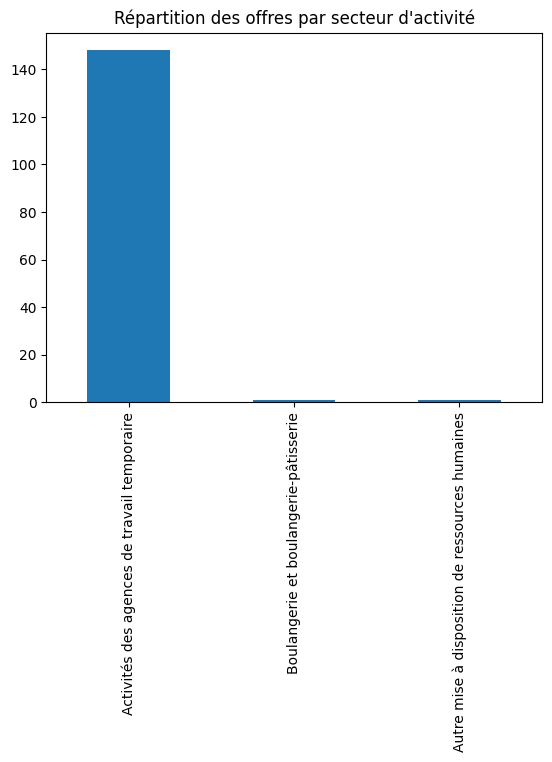

In [0]:
secteur_counts = df_pandas['secteurActiviteLibelle'].value_counts()
secteur_counts.plot(kind='bar', title="Répartition des offres par secteur d'activité")


<Axes: title={'center': 'Répartition des qualifications demandées'}>

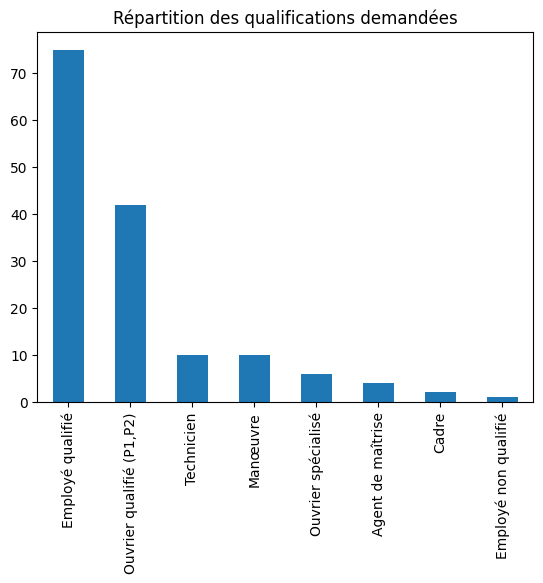

In [0]:
qualification_counts = df_pandas['qualificationLibelle'].value_counts()
qualification_counts.plot(kind='bar', title="Répartition des qualifications demandées")


<Axes: title={'center': 'Répartition des types de contrats'}, ylabel='Contrat'>

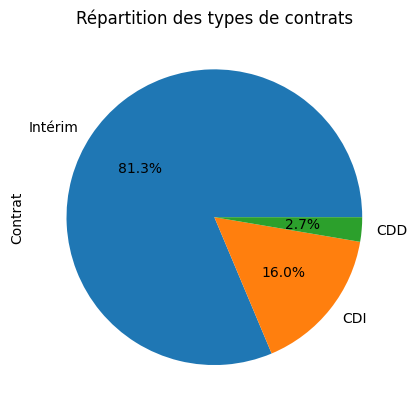

In [0]:
contrat_counts = df_pandas['Contrat'].value_counts()
contrat_counts.plot(kind='pie', autopct='%1.1f%%', title="Répartition des types de contrats")


<Axes: title={'center': "Top 10 des communes avec le plus d'offres"}>

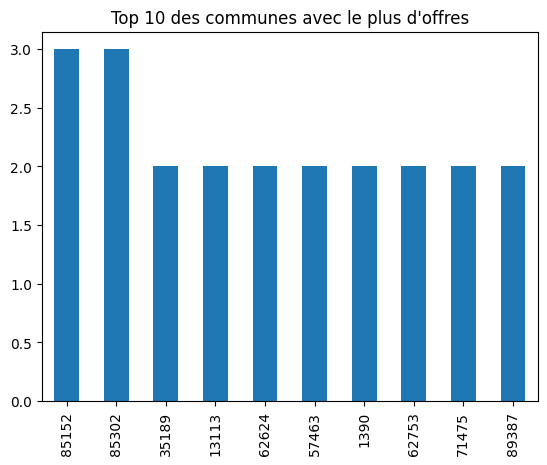

In [0]:
# Convertir les codes communes en entiers puis en chaînes de caractères pour enlever les .0

lieu_counts = df_pandas['lieuTravail.commune'].value_counts().head(10)
lieu_counts.plot(kind='bar', title="Top 10 des communes avec le plus d'offres")


<Axes: title={'center': "Répartition des niveaux d'expérience requis"}>

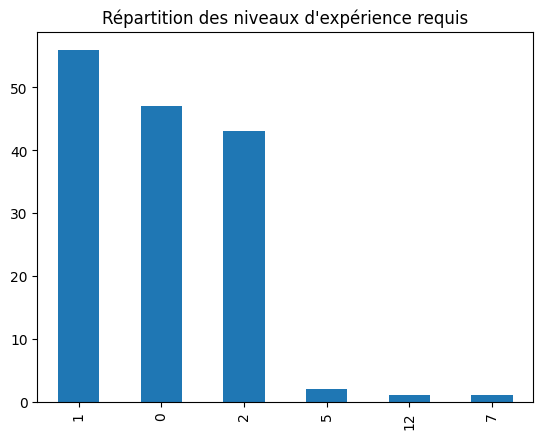

In [0]:
experience_counts = df_pandas['experienceLibelle'].value_counts()
experience_counts.plot(kind='bar', title="Répartition des niveaux d'expérience requis")


<Axes: title={'center': 'Salaire annuels moyen par secteur'}, xlabel='secteurActiviteLibelle'>

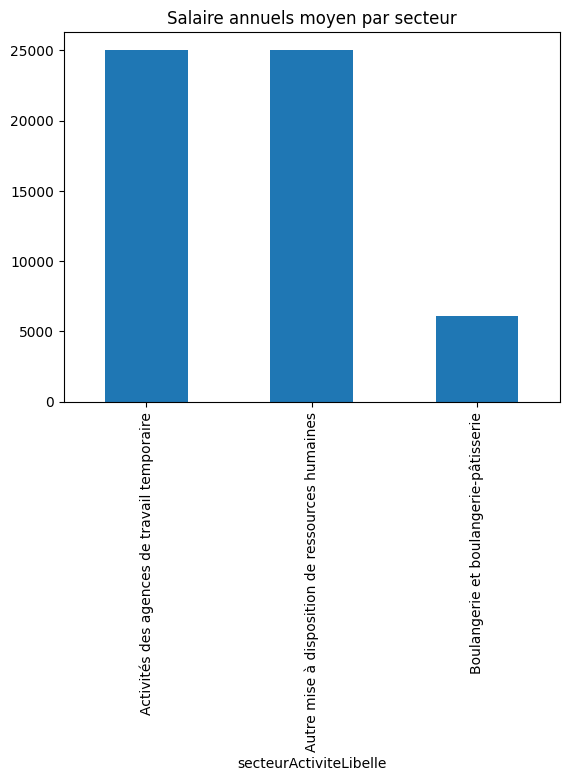

In [0]:
# Si les salaires sont dans un format numérique exploitable
df_pandas['salaire_per_year'] = df_pandas['salaire_per_year'].astype(float)
salaire_moyen_par_secteur = df_pandas.groupby('secteurActiviteLibelle')['salaire_per_year'].mean()
salaire_moyen_par_secteur.plot(kind='bar', title="Salaire annuels moyen par secteur")


#4) Draft

In [0]:
import ast
dataframeML = df_pandas[['salaire_per_year', 'experienceLibelle','secteurActiviteLibelle']]

dataframeML.dropna(inplace=True)


/root/.ipykernel/2735/command-3173368327208671-1682081972:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeML.dropna(inplace=True)


In [0]:

# Remove any remaining non-numeric characters using regex
dataframeML['experienceLibelle'].fillna(0, inplace=True)  # Or dropna() if that's appropriate


/root/.ipykernel/2735/command-3173368327208661-2615656598:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframeML['experienceLibelle'].fillna(0, inplace=True)  # Or dropna() if that's appropriate


In [0]:
df_pandas['secteurActiviteLibelle'].value_counts()

Activités des agences de travail temporaire        148
Boulangerie et boulangerie-pâtisserie                1
Autre mise à disposition de ressources humaines      1
Name: secteurActiviteLibelle, dtype: int64

In [0]:
dataframeML = df_pandas
dataframeML['experienceLibelle'].astype(int)
print(dataframeML['experienceLibelle'].dtype)
dataframeML['experienceLibelle'] = dataframeML['experienceLibelle'].astype(int)
dataframeML['experienceLibelle'].value_counts()

int64


1     56
0     47
2     43
5      2
12     1
7      1
Name: experienceLibelle, dtype: int64

In [0]:
df_pandas.shape[0]

150

# 5) Save our data cleaned in datawarehouse

In [0]:
container_name = "datawarehouse"
mount_point = "/mnt/datawarehouse"  # This is where the container will be mounted in Databricks

# Configuration settings for mounting the container
configs = {
    f"fs.azure.account.key.{account_name}.blob.core.windows.net": account_key
}

# Unmount the directory if it is already mounted
if any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.unmount(mount_point)

# Mount the container to Databricks
dbutils.fs.mount(
    source = f"wasbs://{container_name}@{account_name}.blob.core.windows.net/",
    mount_point = mount_point,
    extra_configs = configs
)

print(f"{container_name} is mounted to {mount_point}")


/mnt/datawarehouse has been unmounted.
datawarehouse is mounted to /mnt/datawarehouse


In [0]:
df_pandas.columns

Index(['id', 'intitule', 'description', 'dateCreation', 'dateActualisation',
       'romeCode', 'romeLibelle', 'appellationlibelle', 'typeContrat',
       'typeContratLibelle', 'natureContrat', 'experienceExige',
       'experienceLibelle', 'dureeTravailLibelle',
       'dureeTravailLibelleConverti', 'qualificationCode',
       'qualificationLibelle', 'codeNAF', 'secteurActivite',
       'secteurActiviteLibelle', 'lieuTravail.libelle', 'lieuTravail.latitude',
       'lieuTravail.longitude', 'lieuTravail.codePostal',
       'lieuTravail.commune', 'entreprise.nom', 'salaire.libelle',
       'contact.coordonnees1', 'origineOffre.origine',
       'origineOffre.urlOrigine', 'contact.nom', 'salaire_per_year',
       'Contrat'],
      dtype='object')

In [0]:
# Step 1: Define the mount point and directory path using dbfs protocol
directory_path = "/dbfs/mnt/datawarehouse/processed_data"

# Step 2: Re-create the directory in Databricks (to ensure path existence)
dbutils.fs.mkdirs(directory_path)
print(f"Directory {directory_path} created or already exists.")

# Step 3: Verify the directory by listing the contents of the parent directory
display(dbutils.fs.ls("/mnt/datawarehouse"))

# Step 4: Define the full output path for the CSV file
output_file_path = f"{directory_path}/APIProcessedData.csv"

# Step 5: Save the DataFrame as a CSV file in the created directory
df_pandas.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")
print("Pipeline terminé, les données transformées ont été enregistrées.")


Directory /dbfs/mnt/datawarehouse/processed_data created or already exists.


path,name,size,modificationTime
dbfs:/mnt/datawarehouse/checkpoints/,checkpoints/,0,1724022513000
dbfs:/mnt/datawarehouse/processed_data/,processed_data/,0,1724022510000


Data saved to /dbfs/mnt/datawarehouse/processed_data/APIProcessedData.csv
Pipeline terminé, les données transformées ont été enregistrées.


## Scatter Plot of Salary per Year vs. Experience Level


In [0]:
dataframeML = df_pandas[[ 'salaire_per_year', 'experienceLibelle','secteurActiviteLibelle']]
dataframeML.head()

,salaire_per_year,experienceLibelle,secteurActiviteLibelle
0,24232.0,0,Activités des agences de travail temporaire
1,24232.0,0,Activités des agences de travail temporaire
2,25000.0,1,Activités des agences de travail temporaire
3,24232.0,0,Activités des agences de travail temporaire
4,24232.0,1,Activités des agences de travail temporaire


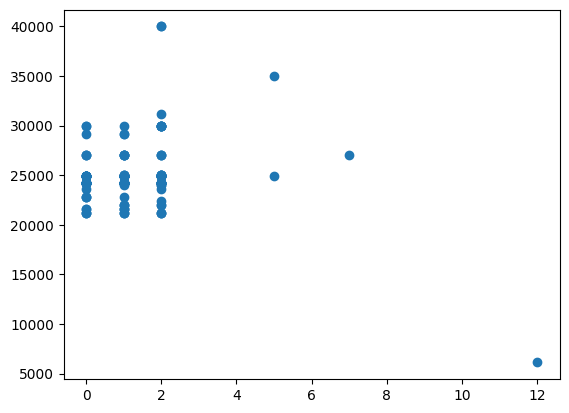

In [0]:
import matplotlib.pyplot as plt
dataframeML[['experienceLibelle', 'salaire_per_year','secteurActiviteLibelle']]
plt.scatter(dataframeML['experienceLibelle'], dataframeML['salaire_per_year'])
plt.show()

# Machine learning

## Data cleaning and processing for models


In [0]:
dataframeML = df_pandas[[ 'salaire_per_year', 'experienceLibelle','secteurActiviteLibelle','Contrat']]
# function to clean typeContractLibelle 

dataframeML.head()
dataframeML['Contrat'].value_counts()

Intérim    122
CDI         24
CDD          4
Name: Contrat, dtype: int64

## Training regression models


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression, Lasso, BayesianRidge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

global X_train , y_train

def train_model(model, model_name, data):
    # Encoder les colonnes catégorielles
    label_encoders = {}
    data = data.copy()  # Make a copy of the DataFrame
    for column in ["secteurActiviteLibelle", "Contrat"]:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])
    # Définir les caractéristiques (features) et la cible (target)
    X = data[["secteurActiviteLibelle", "experienceLibelle", "Contrat"]]
    y = data["salaire_per_year"]

    # Feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Diviser les données en jeu d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    
    model.fit(X_train, y_train)

    # Évaluer le modèle
    score = model.score(X_test, y_test)
    print(f"{model_name} Score (R^2): {score:.2f}\n")


In [0]:

# Instantiate the models
models = [
    Ridge(), 
    LinearRegression(), 
    Lasso(), 
    BayesianRidge(), 
    LogisticRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(), 
    RandomForestRegressor()
]

models_names = [
    "Ridge", 
    "LinearRegression", 
    "Lasso", 
    "BayesianRidge", 
    "LogisticRegression",
    "RandomForest",
    "GradientBoosting",
    "KNN",
    "RandomForestRegressor"
]

for model, model_name in zip(models, models_names):
    train_model(model, model_name, dataframeML)

print('\n')


Ridge Score (R^2): -1.07

LinearRegression Score (R^2): -1.08

Lasso Score (R^2): -1.08

BayesianRidge Score (R^2): -0.95

LogisticRegression Score (R^2): 0.23

RandomForest Score (R^2): -0.68

GradientBoosting Score (R^2): -0.87

KNN Score (R^2): -0.78

RandomForestRegressor Score (R^2): -0.71





##Conclusion
After evaluating multiple models (Ridge, Linear Regression, Lasso, Bayesian Ridge, Logistic Regression, Random Forest, Gradient Boosting, and K-Nearest Neighbors) on our dataset, the performance, as indicated by the R² scores, is relatively low. 
The highest R² score achieved was 0.30 with the Logistic Regression model, meaning that even the best model only explains 30% of the variance in the target variable.

# Trying hyperparameter tuning



hyperparameter tuning using GridSearchCV, which systematically searched through different values of n_estimators (number of trees) and max_depth (maximum depth of the trees). 
tried it on the linear logistic regression
The tuning process found the best combination of these hyperparameters for my  data, resulting in a better fit and a better R² score
![](path)

In [0]:
from sklearn.model_selection import GridSearchCV
import numpy as np
# Define a simple parameter grid for RandomForest
param_grid = {
    'C': np.logspace(-3,3,7),
    'max_iter': [100, 1000, 5000, 10000,50000, 100000],
    'penalty': ['l2']
}

# Initialize the model
lr = LogisticRegression()
label_encoders = {}
data = dataframeML.copy()

for column in ["secteurActiviteLibelle", "Contrat"]:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])
# Définir les caractéristiques (features) et la cible (target)
X = data[["secteurActiviteLibelle", "experienceLibelle", "Contrat"]]
y = data["salaire_per_year"]

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid)
grid_search.fit(X_train, y_train)
# Print the best parameters and R² score
print(grid_search.best_estimator_)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R² score: {grid_search.best_score_:.2f}")


/databricks/python/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scik

LogisticRegression(C=10.0)
Best parameters: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2'}
Best R² score: 0.34


In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define a simple parameter grid for RandomForest
param_grid = {
    'n_estimators': [10, 15, 30, 50, 100, 200],
    'max_depth': [None, 2, 5, 10, 20, 30]
}

# Initialize the model
rf = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# print(grid_search.score(X_test, y_test))
# Print the best parameters and R² score
print(grid_search.best_estimator_)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R² score: {grid_search.best_score_:.2f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.1s
[CV] END .......................max_depth=5, n_

Best parameters in our case:
C : 0.001
max_iter : 100
penalty: l2 
, So we tried it 

In [0]:
lr = LogisticRegression(C=0.001, max_iter=100, penalty='l2')
lr.fit(X_train, y_train)
print(f"accuracy = {lr.score(X_test, y_test):.2f}")


accuracy = 0.40


In this experiment, I used a logistic regression to model the data. 
To optimize the model's performance, I performed hyperparameter tuning using GridSearchCV with 5-fold cross-validation. 
The parameters I tuned were the number of trees (n_estimators) and the maximum depth of the trees (max_depth).

This model achieved an R² score of 0.33, indicating that it explains 33% of the variance in the target variable. This result represents a considerable improvement over simpler models, making the logistix Regression a suitable choice for this dataset.

In [0]:
!pip install imblearn
!pip install xgboost


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
